# The entirety of this study was conducted on google colab

Final copy of the Jupyter notebook for my master degree research
Topic: Medical Image Data Augmentation Using Generative Adversarial Network (GAN). Case study of the NIH  lungs dataset on kaggle

The steps to follow in this project are as follows


*   Exploratory data analysis and Image preprocessing
*   Building and running the GAN model to generate the synthetic images

*   Data Preprocessing for the GAN model and involves
1.   loading the dataset set
2.   Creating a new column name path that will store all the the path link to each individual image
3.   Using onehot-encoding to create the y-truth value for each image
4.   Subsetting a single pathology to be used for the GAN model


* The CNN model Process
*   Running a deep neural network classification model on images using the selected pathology and an approximately equal subset of healthy lungs images as the base model
*   Evaluate the accuracy of the base model for comparitive analysis.
*   Concatnate the generated synthetic image with the real images used in the training dataset, Train and evaluate the CNN model on this new dataset and measure the change in the classification models accuracy
* Concatnate the generated images with the entire trsining dataset. Train and evaluate the model accuracies and matrics






# Mounting the drive and importing all the libraries needed for the analysis

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
## Data preprocessing modules
import numpy as np
import seaborn as sns
import pandas as pd
import os
import glob
import itertools
import time
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from IPython import display
import pickle


# CNN and DCGAN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, ReLU, MaxPooling2D, Flatten, Dropout, Dense, Softmax
from keras.callbacks import EarlyStopping
# Image Processing and model accuracy visualization modules
from pandas import DataFrame
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# DCGAN MODULES

from torchvision import transforms
from torch.utils.data import Dataset

import torchvision.utils as vutils
import torch
import torch.nn as nn



import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML



In [ ]:
# clear session The tensor flow backend to prevent the  models from relearning what it already learnt before it
backend.clear_session()

# Loading the data for exploratory analsysis of the dataset.


In [ ]:
#Importing the dataset
df = pd.read_csv("/content/drive/MyDrive/NIH/Data_Entry_2017.csv")
#Making a copy of the dataset and visualizing it to understand the structure of the dataset
lungs_df = df.copy()
lungs_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


The Dataset contains a total of 112120 entries of lungs radiological images with some images containing multiple pathologies. Other important columns in the dataset are the "Patients_Age" and "Patients_ID" which can be relevant in the classification model to resolve issues of data spillover. This relates to where a patient have multiple images and using the trian_test_plit will result in the a patient being image bieng in the trianing and testing dataset which  compromise the validtion accuracy of the model.

NB. because i am subsetting a single pathology, this issue may not accor because the number of observations will be significantly reduced.
Also for the GAN model, it is not neccesary to evaluate the issues of data spill over

### some of the name columns in the dataset has issuses and are corrected below for ease of manipulation

In [ ]:
# Rename the columns
_lungs_df = df.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalImagePixelSpacingX",
    "y]": "OriginalImagePixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})
lungs_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


# Using onehot_encoding to format the "Finding Labels" column.
## This will create 15 new columns with each column representing each column pathology in the "Finding Labels" column with 1.0 as for a positive diagnosis and 0.0 for a negative diagnosis for each images

### Since only one pathology will be chosen for this analysis, their is no need to conduct a comprehensive analysis exploratory data analysis of the entire dataset and thus the exploratory data analysis will be focused only on the on the dataset the contains the relevant images

In [ ]:
### Format the label by a one hot encoding

# Get all the label
unique_labels = set(itertools.chain.from_iterable(lungs_df["Finding Labels"].apply(lambda x : x.split('|')).values))

# Initialize a empty matrix
one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(lungs_df)), columns=list(unique_labels))

# For each row, we get the associated labels and set a 1 to the new corresponding column label
for index, row in lungs_df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

# Then, we concatane this new dataframe to our original data
lungs_df = pd.concat([lungs_df, one_hot_labels], axis=1)

lungs_df.head()



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Pneumonia,Atelectasis,Consolidation,Emphysema,Infiltration,Mass,Nodule,Pneumothorax,Fibrosis
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## The dataset has a total of 14 identified pathologies with significant amount of healthy images labeled as "No Finding". The count total of the images based on the pathologies are given in the figure below.
## Note that some of the images has multiple diagnosis meaning that a single image can contain more than 1 disease in them.

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
lungs_df["Finding Labels"].value_counts()


No Finding                                                                                              60361
Infiltration                                                                                             9547
Atelectasis                                                                                              4215
Effusion                                                                                                 3955
Nodule                                                                                                   2705
Pneumothorax                                                                                             2194
Mass                                                                                                     2139
Effusion|Infiltration                                                                                    1603
Atelectasis|Infiltration                                                                                 1350
Consolidat

##Taking a count value of the pathologies based on if the appear in any image "Finding Labels"  using the .str concatnation, we will get the following count values.
## The result contained here include single and multiple count values for each pathologies.

In [ ]:
# Split the combined variables using the "|" delimiter and create a Series
all_labels = df['Finding Labels'].str.split('|', expand=True).stack()

# Use value_counts to count the occurrences of each label
label_counts = all_labels.value_counts()

print(label_counts)

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


# Creating a new column named path for the images that will contain the path that points to each individual image which will serve as the column for training both the GAN and CNN models images for the analysis

## Writing a function that search all the directories, and multiple sub-directories to find the path for each image and afficing the result to an empty list

In [ ]:
#Specify the base directory containing your subfolders
base_directory = '/content/drive/MyDrive/NIH/'

# Initialize an empty dictionary to store image paths
all_image_paths = {}

# Loop through subfolders "images_001" to "images_012"
for subfolder_number in range(1, 13):
    subfolder_name = f'images_{subfolder_number:03}'  # Format subfolder name with leading zeros
    subfolder_path = os.path.join(base_directory, subfolder_name, 'images')

    # Check if the subfolder exists
    if os.path.exists(subfolder_path):
        # Use os.listdir to get a list of files in the 'images' subfolder
        image_filenames = os.listdir(subfolder_path)

        # Create a dictionary mapping image filenames to their full file paths
        image_paths_dict = {filename: os.path.join(subfolder_path, filename) for filename in image_filenames}

        # Update the all_image_paths dictionary with the current subfolder's image paths
        all_image_paths.update(image_paths_dict)

# Now, all_image_paths contains a mapping of image filenames to their full file paths from all subfolders



### Mapping the path generated by the above for loop to the general "Image Index column to generate create the path column that points to each individual image

In [ ]:
### Creating a list of the pathology
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule',
                  'Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema',
                  'Consolidation','Infiltration','Fibrosis','Pneumonia']


### The path column is added to the dataframe here which contains the path to each image in the dataset

In [ ]:
# Defining the path column
lungs_df['path'] = lungs_df['Image Index'].map(all_image_paths.get)
# Printing the first five columns of the dataset to ensure the paths to the files are accurate.
lungs_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pneumonia,Atelectasis,Consolidation,Emphysema,Infiltration,Mass,Nodule,Pneumothorax,Fibrosis,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/NIH/images_001/images/0...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/NIH/images_001/images/0...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/NIH/images_001/images/0...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/NIH/images_001/images/0...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/NIH/images_001/images/0...


## Because it takes time for the image to preprocess and create the path fro each individual image, the result of this above preprocessing is converted to a CSV file to prevent prepeating the process multiple times.



In [ ]:
# Defining the part to save the image on
csv_path = '/content/drive/MyDrive/NIH/df1_path.cs'

# Save the DataFrame to a CSV file
lungs_df.to_csv(csv_path, index=False)

### Importing the new csv file for the remaining path of the analysis

In [3]:
lungs_df = pd.read_csv("/content/drive/MyDrive/NIH/df1_path.csv")

### Subsetting only the relevant columns needed in the analysis and concatnating them to a dataframe

In [4]:
columns_labels = ['Image Index','Finding Labels','path','No Finding','Cardiomegaly','Emphysema',
                  'Effusion','Hernia','Nodule','Pneumothorax','Atelectasis',
                  'Pleural_Thickening','Mass','Edema','Consolidation',
                  'Infiltration','Fibrosis','Pneumonia']


labels_dataset = pd.DataFrame(lungs_df, columns=columns_labels)

In [5]:
labels_dataset.head()

,Image Index,Finding Labels,path,No Finding,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00000001_000.png,Cardiomegaly,/content/drive/MyDrive/NIH/images_001/images/0...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,/content/drive/MyDrive/NIH/images_001/images/0...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,/content/drive/MyDrive/NIH/images_001/images/0...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,/content/drive/MyDrive/NIH/images_001/images/0...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,/content/drive/MyDrive/NIH/images_001/images/0...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Subsettting the dataset based on the truth values of one of the pathologies (Infiltration). The choice of Infiltration is because it has the highest number of images with single pathologies.



In [9]:
# Specify the label you want to filter
target_label = 1.0

# Filter the dataset to get images with the desired label
filtered_dataset = labels_dataset[labels_dataset['Finding Labels'] == "Infiltration"]
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9547 entries, 19 to 112100
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image Index         9547 non-null   object 
 1   Finding Labels      9547 non-null   object 
 2   path                9547 non-null   object 
 3   No Finding          9547 non-null   float64
 4   Cardiomegaly        9547 non-null   float64
 5   Emphysema           9547 non-null   float64
 6   Effusion            9547 non-null   float64
 7   Hernia              9547 non-null   float64
 8   Nodule              9547 non-null   float64
 9   Pneumothorax        9547 non-null   float64
 10  Atelectasis         9547 non-null   float64
 11  Pleural_Thickening  9547 non-null   float64
 12  Mass                9547 non-null   float64
 13  Edema               9547 non-null   float64
 14  Consolidation       9547 non-null   float64
 15  Infiltration        9547 non-null   float64
 16  Fib

# Visualizing the infiltration images first in RGB and second in grayscale and confirming the size of the images in the disk

Image 1 shape: (1024, 1024)
Image 2 shape: (1024, 1024)
Image 3 shape: (1024, 1024)
Image 4 shape: (1024, 1024)
Image 5 shape: (1024, 1024)
Image 6 shape: (1024, 1024)
Image 7 shape: (1024, 1024)
Image 8 shape: (1024, 1024)
Image 9 shape: (1024, 1024)
Image 10 shape: (1024, 1024)


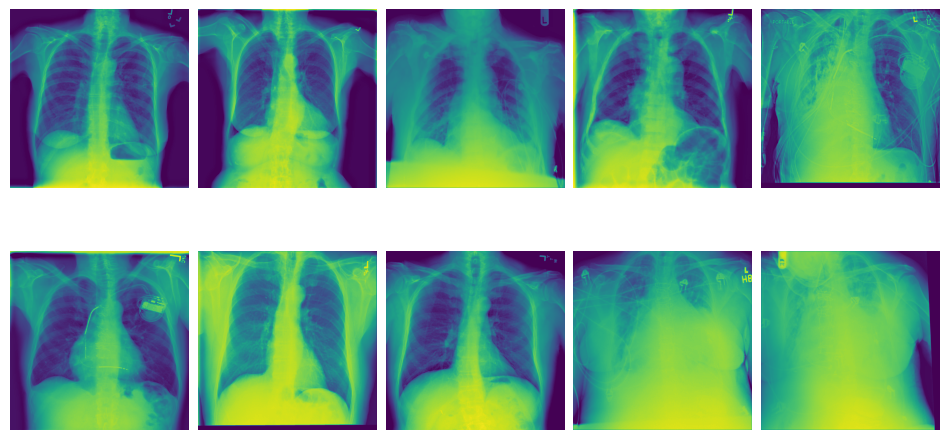

In [ ]:
# List of image file paths

image_paths = filtered_dataset['path'].values
# Number of rows and columns in the grid
num_rows = 2
num_cols = 5

# Calculate the total number of images to display (should be <= num_rows * num_cols)
num_images_to_display = min(len(image_paths), num_rows * num_cols)

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes array to simplify indexing
axes = np.ravel(axes)

# Loop through and display the images in the grid
for i in range(num_images_to_display):
    if i < len(image_paths):
        # Load the image
        img = mpimg.imread(image_paths[i])

        # Print the shape of the image
        print(f"Image {i + 1} shape: {img.shape}")

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axis labels and ticks
    else:
        # If there are fewer images than grid cells, leave the empty cells blank
        axes[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Display the grid of images
plt.show()


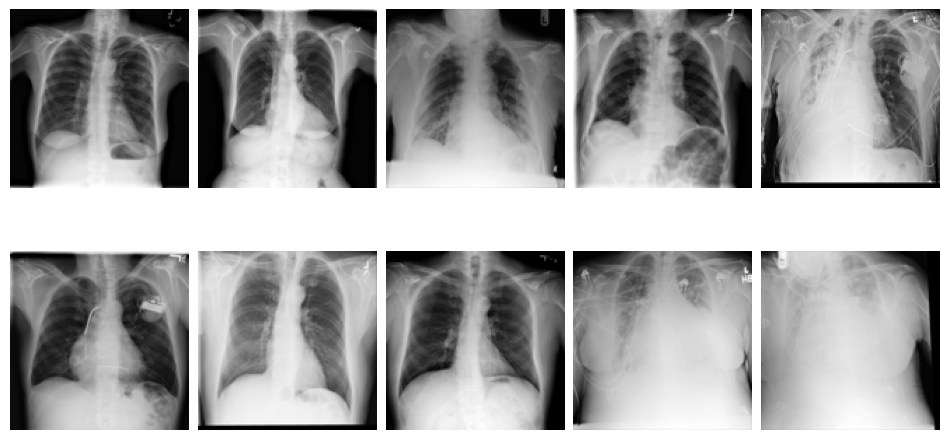

In [ ]:
## Visualizing the images in grayscale
# Number of rows and columns in the grid
num_rows = 2
num_cols = 5

# Calculate the total number of images to display (should be <= num_rows * num_cols)
num_images_to_display = min(len(image_paths), num_rows * num_cols)

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes array to simplify indexing
axes = np.ravel(axes)

# Loop through and display the first 10 images in the grid
for i in range(num_images_to_display):
    if i < len(image_paths):
        # Load the color image
        color_image = Image.open(image_paths[i])

        # Convert to grayscale
        grayscale_image = color_image.convert("L")  # "L" mode indicates grayscale

        # Resize to (224, 224)
        grayscale_image = grayscale_image.resize((128, 128))

        # Convert to a NumPy array
        grayscale_array = np.array(grayscale_image)

        # Ensure the shape is (224, 224, 1)
        grayscale_array = grayscale_array.reshape((128, 128, 1))

        # Display the grayscale image
        axes[i].imshow(grayscale_array[:, :, 0], cmap="gray")
        axes[i].axis('off')  # Hide axis labels and ticks
    else:
        # If there are fewer images than grid cells, leave the empty cells blank
        axes[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Display the grid of grayscale images
plt.show()

This shows that the images a quite large which will explain the reason why it takes time to load and the total file size of 45GB

# GENERATIVE ADVERSARIAL NETWORK.
## The following define the image preporcesing and the development of the GAN model. For this project, DCGAN (Deep Convolutional Generative Advaserial Network) will be used and the process is defined in the the link below
https://www.tensorflow.org/tutorials/generative/dcgan

### Note the procedure given in the link was modified to suite the characteristics of the in=mages in this study.


In [ ]:
# Subsetting The infiltation images path for The GAN model
filtered_dataset = filtered_dataset[["Image Index", "Finding Labels", "path"]]
filtered_dataset

,Image Index,Finding Labels,path
19,00000005_006.png,Infiltration,/content/drive/MyDrive/NIH/images_001/images/0...
27,00000010_000.png,Infiltration,/content/drive/MyDrive/NIH/images_001/images/0...
33,00000011_005.png,Infiltration,/content/drive/MyDrive/NIH/images_001/images/0...
35,00000011_007.png,Infiltration,/content/drive/MyDrive/NIH/images_001/images/0...
45,00000013_007.png,Infiltration,/content/drive/MyDrive/NIH/images_001/images/0...
...,...,...,...
112055,00030756_000.png,Infiltration,/content/drive/MyDrive/NIH/images_012/images/0...
112056,00030757_000.png,Infiltration,/content/drive/MyDrive/NIH/images_012/images/0...
112062,00030763_000.png,Infiltration,/content/drive/MyDrive/NIH/images_012/images/0...
112070,00030770_001.png,Infiltration,/content/drive/MyDrive/NIH/images_012/images/0...


## Loading the images with infiltration parameters and defining the image size of 128x128 to speed op the GAN training process. Note this image size will also be used for the CNN training model

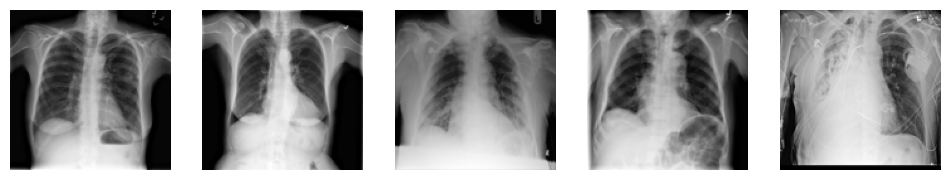

In [ ]:
# Assuming "path" contains image paths and "filtered_dataset" is a pandas DataFrame
image_paths = filtered_dataset["path"].values

# Load and preprocess images with resizing and conversion to grayscale
resized_images = []
target_size = (128, 128)

for path in image_paths:
    img = Image.open(path).convert('L').resize(target_size)  # Convert to grayscale and resize
    img_array = np.array(img, dtype=np.float32)
    resized_images.append(img_array)

# Convert the list of resized images to a NumPy array
train_images = np.array(resized_images)

# Normalize the images
train_images = (train_images - 127.5) / 127.5

# Display a sample of images
num_samples_to_display = 5  # You can adjust this number
sample_images = train_images[:num_samples_to_display]

# Plot the images
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(12, 4))

for i in range(num_samples_to_display):
    axes[i].imshow(sample_images[i].reshape(128, 128), cmap='gray')  # Ensure cmap is set to 'gray' for grayscale images
    axes[i].axis('off')

plt.show()


### Defining  the traing BUFFER_SIZE which is the total number of images from which the training model will randomly select the batch size training image and also the batch_size which the total number of image usinged to taraining the GAN at each epoch and iteration

### To reduce the time spent on preprocessing this image for the GAN model, The preprocessing was carried out in a personal system and the results save as a pickle file and uploaded to google drive.
### The resilting infiltration pikle File is imported into the workbook below

In [ ]:
import pickle

# Replace 'MyFiles/your_file.pkl' with the actual path to your file
file_path = "/content/drive/MyDrive/infiltration.pkl"

with open(file_path, 'rb') as file:
    train_images = pickle.load(file)

In [ ]:
# Defining the buffer_size. This corresponds to the total number of infiltration images in the dataset
BUFFER_SIZE = 9547
# Defning the Batch_size
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Defining the Generator Function for the training of the GAN. The  generator has over 4 layers with  batch normalization and LeakyReLU ans the activation function. ALso the models Noise parameter is added using tensorflow random normal funtion when calling the Generator fcuntion

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26214400  
                                                                 
 batch_normalization (Batch  (None, 262144)            1048576   
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       5

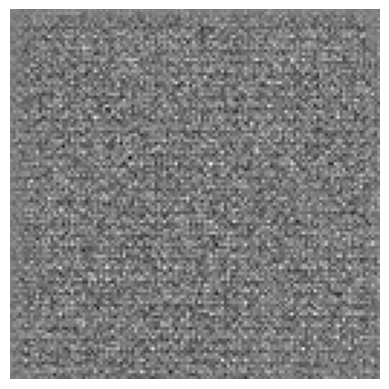

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Create the generator model
generator = make_generator_model()

# Print the generator summary to check its architecture
generator.summary()

# Now, generate an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

## Defining the Discriminator function and calling the discriminator model.

In [ ]:
# Defining the discriminator function and calling the functions
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Calling the discriminator function and generatinhg the images tnsor
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00097504]], shape=(1, 1), dtype=float32)


### GAN works to differentiate fake from the real and fake image meaning it is a binary algorithma dn thus binarycrossenthropy eill be used for this analysis.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


## Defining a function that will quantify how well the discriminator is performing in distingiushing between real and fake samples while measuring the real_loss and Fake_loss of the model

In [ ]:
def discriminator_loss(real_output, fake_output):
    # Define a binary cross-entropy loss for the real samples
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Define a binary cross-entropy loss for the fake samples
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # The total discriminator loss is the sum of the real and fake losses
    total_loss = real_loss + fake_loss

    # Return the total discriminator loss
    return total_loss

### Similarly defining the generator loss function

In [ ]:
def generator_loss(fake_output):
    # Use binary cross-entropy loss to encourage the generator to make the fake output look real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Defining the generator and discriminator optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Creating Training checkpionts to ensure that are used to save model parameters duringh training so tha you can later resume training or use the trained model for inference

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Defining the number of epochs, noise_dim and the number of samples of generated images to save per epoch

In [ ]:
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 50

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Defining the training steps which consist of updating the wieghts of both the generator and discriminator networks based on the gradients of their respective loss functions


In [ ]:
@tf.function
def train_step(images):
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images using the generator
        generated_images = generator(noise, training=True)

        # Compute discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients of losses with respect to trainable variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update generator and discriminator weights using the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


###This code iterates through the training dataset for a specified number of epochs, performs a training step for each batch of images, and then periodically saves generated images and checkpoints the model

In [ ]:
def train(train_dataset, epochs):
    # Lists to store generator and discriminator losses for each epoch
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in train_dataset:
            train_step(image_batch)

        # Produce images for visualization
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Calculate generator and discriminator losses for the current epoch
        noise = tf.random.normal([num_examples_to_generate, noise_dim])
        generated_images = generator(noise, training=False)
        real_output = discriminator(image_batch, training=False)
        fake_output = discriminator(generated_images, training=False)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Append losses to the lists
        generator_losses.append(gen_loss.numpy())
        discriminator_losses.append(disc_loss.numpy())

        # Print the time taken for the current epoch
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}, Time: {time.time()-start} sec')

    # Plot the generator and discriminator losses over epochs
    plt.plot(range(1, epochs + 1), generator_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Generate and save images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


### Defining a function that saves 50 individaul images per epoch

In [ ]:
def generate_and_save_images(model, epoch, test_input, colab_directory='/content/drive/MyDrive/DCGAN5/'):
    # Generate predictions using the generator model
    predictions = model(test_input, training=False)

    # Create a directory for each epoch in Colab
    epoch_directory = f'{colab_directory}/epoch_{epoch:04d}'
    if not os.path.exists(epoch_directory):
        os.makedirs(epoch_directory)

    # Iterate over generated images and save them
    for i in range(predictions.shape[0]):
        # Display the image without axis
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

        # Save each image individually
        image_filename = f'{epoch_directory}/epoch_{epoch}_image_{i:03d}.png'
        plt.savefig(image_filename)
        plt.clf()  # Clear the current figure to start fresh for the next image

    # Print a message indicating that images for the epoch have been saved
    print(f'Images for epoch {epoch} saved to {epoch_directory}')


# Training the model

In [ ]:
train(train_dataset, EPOCHS)

Images for epoch 2000 saved to /content/drive/MyDrive/DCGAN5//epoch_2000


<Figure size 640x480 with 0 Axes>

# The Convolutional Neural Network(CNN) MODELS
## CNN model will be used the measure the quality of the generated synthetic images. The CNN model will be self defined and not with without using pretrained weights. The reason for this choice is that the model is this researc is based on generation of GAN and not the accuracy of CNN models. to this effect, 3 classification model will be used for this purpose with no hyper parameter tuning. The difference in the two models will be based on the Training dataset used and the conditions for the two models will be as follows
### 1.   The first model will be based on based on a train test split the a subset of the chosen pathology and random healthy lung
### 2.  For the second CNN model, the test set will remain the same while the training dataset will contian the initail training dataset and 50% of generated synthetic images concatnated together.
### 2. For the third model, the Integration of the synthetic GANs will follow the same process as the other data augmentation techniques and thus will be present in both the training and test dataset. Meaning the concatnation will be performed before splitting the data into training and test dataset
  



In [ ]:
# Filter rows with 'edema' label
Infiltration_df = lungs_df[lungs_df['Finding Labels'] == "Infiltration" ]  # Assuming 'label' is the column containing class labels


# Filter rows with 'normal' label, keeping only 3000 samples
normal_data = lungs_df[lungs_df['Finding Labels'] == 'No Finding'].sample(n=10000)

# Concatenate the 'Edema' and 'No Standing' subset data
subset_data = pd.concat([Infiltration_df, normal_data])

# Reorganizing the index
subset_data = subset_data.sample(frac=1, random_state=42).reset_index(drop=True)
subset_data


# This i
class_dataset = subset_data[['Image Index','Finding Labels','path','Infiltration']]
class_dataset = class_dataset.rename(columns={
    "Infiltration": "Labels",

})
X = class_dataset["path"].values  # Input features (file paths)
y = class_dataset["Labels"].values  # Target labels

# Split the data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



### Defining a function that takes the images and converst it into an input shape if (128, 128, 3)


In [ ]:
def load_and_preprocess_image(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Set the desired image size
    image = image.convert('RGB')  # Ensure the image has three color channels (RGB)
    image = np.array(image) / 255.0  # Normalize pixel values to the range [0, 1]
    return image

# To test the models performance with an on a grayscale image, The loading function can be modififed to conveert the image to 128,128,1 as follows

### Visualizing the imnage loading functions on the first image in the training dataset

In [ ]:
single_image_path = X_train[0]  # Change this to a valid path in X_train
single_image = load_and_preprocess_image(single_image_path)
single_image

array([[[0.        , 0.        , 0.        ],
        [0.02745098, 0.02745098, 0.02745098],
        [0.16078431, 0.16078431, 0.16078431],
        ...,
        [0.38823529, 0.38823529, 0.38823529],
        [0.6745098 , 0.6745098 , 0.6745098 ],
        [0.97647059, 0.97647059, 0.97647059]],

       [[0.        , 0.        , 0.        ],
        [0.02352941, 0.02352941, 0.02352941],
        [0.14901961, 0.14901961, 0.14901961],
        ...,
        [0.03529412, 0.03529412, 0.03529412],
        [0.23921569, 0.23921569, 0.23921569],
        [0.68235294, 0.68235294, 0.68235294]],

       [[0.        , 0.        , 0.        ],
        [0.03137255, 0.03137255, 0.03137255],
        [0.14509804, 0.14509804, 0.14509804],
        ...,
        [0.        , 0.        , 0.        ],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.41960784, 0.41960784, 0.41960784]],

       ...,

       [[0.59215686, 0.59215686, 0.59215686],
        [0.54901961, 0.54901961, 0.54901961],
        [0.41176471, 0

In [ ]:
# # Print the shape of X_train before reshaping
# print("X_train shape before reshaping:", single_image.shape)

# Converting the dataset to a numpy array


In [ ]:
# Load and preprocess training and validation images
X_train = np.array([load_and_preprocess_image(file_path) for file_path in X_train])
X_val = np.array([load_and_preprocess_image(file_path) for file_path in X_val])

## Converting the X_trian and X_val  to a pickle file for easy loading

In [ ]:
# Defining the part to the pickle file
pickle_file_path = "/content/drive/MyDrive/X_train.pkl"

# Create and write to the pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(X_train, file)

print(f'Successfully created {pickle_file_path}')

Successfully created /content/drive/MyDrive/X_train.pkl


In [ ]:

# Replace 'MyFiles/your_file.pkl' with the actual path to your file
file_path = "/content/drive/MyDrive/X_train.pkl"

with open(file_path, 'rb') as file:
    X_train = pickle.load(file)

X_train

array([[[[0.64705882, 0.64705882, 0.64705882],
         [0.58431373, 0.58431373, 0.58431373],
         [0.52941176, 0.52941176, 0.52941176],
         ...,
         [0.56470588, 0.56470588, 0.56470588],
         [0.59215686, 0.59215686, 0.59215686],
         [0.60784314, 0.60784314, 0.60784314]],

        [[0.34117647, 0.34117647, 0.34117647],
         [0.18039216, 0.18039216, 0.18039216],
         [0.11764706, 0.11764706, 0.11764706],
         ...,
         [0.43921569, 0.43921569, 0.43921569],
         [0.4745098 , 0.4745098 , 0.4745098 ],
         [0.49803922, 0.49803922, 0.49803922]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.08235294, 0.08235294, 0.08235294],
         [0.11372549, 0.11372549, 0.11372549],
         [0.15686275, 0.15686275, 0.15686275]],

        ...,

        [[0.67058824, 0.67058824, 0.67058824],
         [0.62745098, 0.62745098, 0.62745098]

In [ ]:
# Defining the part to the pickle file
pickle_file_path1 = "/content/drive/MyDrive/X_val.pkl"

# Create and write to the pickle file
with open(pickle_file_path1, 'wb') as file:
    pickle.dump(X_val, file)

print(f'Successfully created {pickle_file_path1}')

Successfully created /content/drive/MyDrive/X_val.pkl


In [ ]:
# Replace 'MyFiles/your_file.pkl' with the actual path to your file
file_path = "/content/drive/MyDrive/X_val.pkl"

with open(file_path, 'rb') as file:
    X_val = pickle.load(file)

X_val

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

# Defining the CNN model
## The CNN model is biult with 3 convolutional layers, max poling, relua activation function and sigmoid activation functions for the dense layer


In [7]:

image_size = (128, 128)
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Initializing the model with 10 epochs and
num_epochs = 15
# Compile the model
model.compile(optimizer=Adam(),  # You can choose a different optimizer if needed
              loss='binary_crossentropy',  # Assuming binary classification
              metrics=['accuracy'])
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',  # or 'val_accuracy'
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore the model weights from the epoch with the best value of the monitored quantity






## The model was  compiled with Adam because of the its ability to dynamically adjust thye learning rate during training.Early stopping was implimented with a patience=3 on the validation accuracy

Epoch 1/15
489/489 [==============================] - 22s 23ms/step - loss: 0.6864 - accuracy: 0.5439 - val_loss: 0.6739 - val_accuracy: 0.5726
Epoch 2/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6757 - accuracy: 0.5690 - val_loss: 0.6721 - val_accuracy: 0.5844
Epoch 3/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6687 - accuracy: 0.5826 - val_loss: 0.6685 - val_accuracy: 0.5747
Epoch 4/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6623 - accuracy: 0.5881 - val_loss: 0.6581 - val_accuracy: 0.5997
Epoch 5/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6587 - accuracy: 0.5938 - val_loss: 0.6638 - val_accuracy: 0.5872
Epoch 6/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6566 - accuracy: 0.5932 - val_loss: 0.6561 - val_accuracy: 0.6020
Epoch 7/15
489/489 [==============================] - 9s 18ms/step - loss: 0.6523 - accuracy: 0.6024 - val_loss: 0.6601 - val_accuracy: 0.594

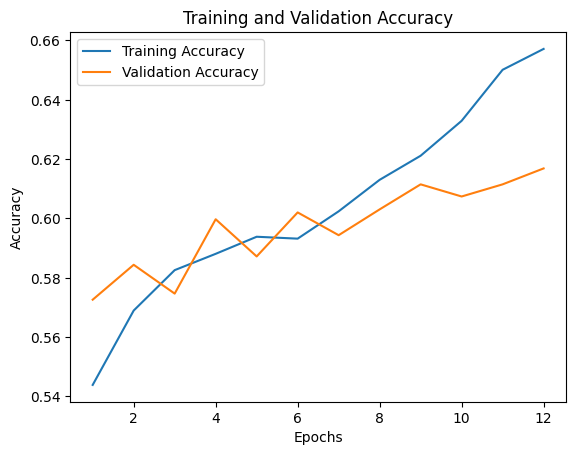

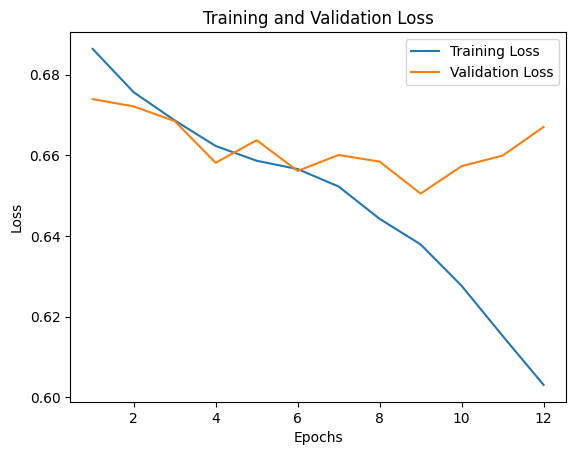

In [ ]:

# Train the model and get the training history
base_model = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the validation data
validation_loss, validation_accuracy = base_model.model.evaluate(X_val, y_val)
print("Validation accuracy:", validation_accuracy)

## Plotting the Training and validation accuracy curve

# Access training history for accuracy and loss
training_accuracy = base_model.history['accuracy']
validation_accuracy = base_model.history['val_accuracy']
training_loss = base_model.history['loss']
validation_loss = base_model.history['val_loss']


# Plot training and validation accuracy
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy',)
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/Btrain_validation.png")

# Training and validation loss plot
plt.figure()  # Create a new figure for the loss plot
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/Btrain_validation_loss.png")

plt.show()

# Calculating the Confusion Matrix
## Defining a function that takes a model and plot the ROC curve

In [17]:
def plot_roc_curve(model, X_val, y_val, model_name='Model', save_path=None):
    # Get predicted probabilities for the positive class
    y_val_probabilities = model.predict(X_val)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probabilities)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    print("{} AUC: {:.2f}".format(model_name, roc_auc))

    # Plot ROC curve
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - {}'.format(model_name))
    plt.legend(loc='lower right')

    if save_path:
      plt.savefig(save_path)

    plt.show()


## Calling the ROC function for the base model

123/123 [==============================] - 1s 6ms/step
Base Model AUC: 0.66


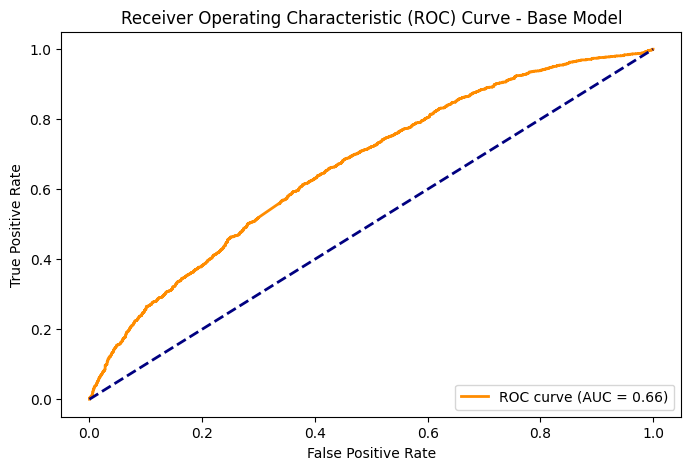

In [ ]:
save_path = ("/content/drive/MyDrive/GANPlots/BM_roc.png")
plot_roc_curve(model, X_val, y_val, model_name='Base Model', save_path= save_path)

### Calculating the Confusion Matrix for the base Models

123/123 [==============================] - 1s 8ms/step - loss: 0.6505 - accuracy: 0.6115
Validation loss: 0.6505074501037598
123/123 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

         0.0       0.61      0.70      0.65      2012
         1.0       0.62      0.51      0.56      1898

    accuracy                           0.61      3910
   macro avg       0.61      0.61      0.61      3910
weighted avg       0.61      0.61      0.61      3910



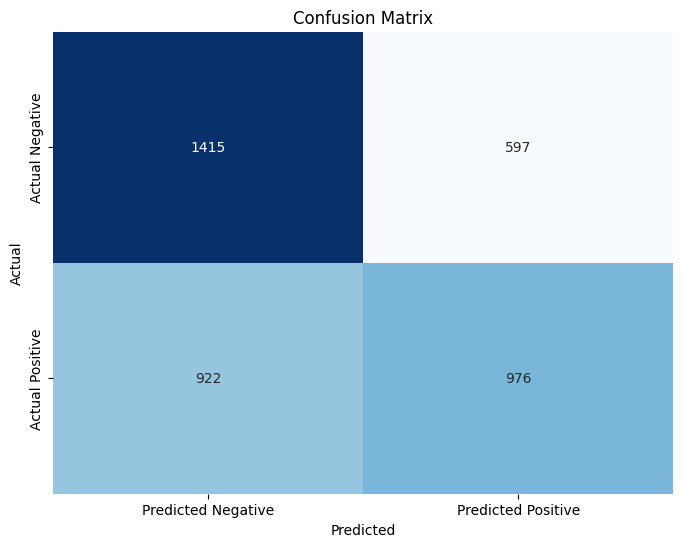

In [ ]:
# Evaluate the model on the validation data
validation_loss = model.evaluate(X_val, y_val)[0]
print("Validation loss:", validation_loss)

# Get predicted probabilities for the validation set
validation_probabilities = model.predict(X_val)

# Convert predicted probabilities to class predictions
y_val_predictions = (validation_probabilities > 0.5).astype(int)

## printing the classsification reports

BMReport = classification_report(y_val, y_val_predictions)
print(BMReport)
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_val, y_val_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Section three of the Analysis

Creating a new csv file called Edema that contains the following columns
1. Image index conatining only the name name of the generated images
2. "Labels" containing the value 1 representing the truth value of edema
3. "Finding Labels" with the value Edema.

A third column named "path" will be created to ensure that the edema.csv matches with the value of the classification dataset for ease of concatnation of the two files and also to ensure ease of subsetting the percentage of the generated files that will be in the training dataset


NB: The generated dataset will only be in the training dataset and cannot be missed withe the text dataset


## Visualizing the first 10 Generated GANs Images


# Loading the images and using the path to each image to create a dataframe called dcgan1.csv with columns "path" containing the path to each image and "Labels" containing the 1.0 as the label for Infiltration.


In [ ]:
# Function to find all image paths in subdirectories
def find_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Path to the directory where the images are saved
google_drive_dir = '/content/drive/My Drive/DCGAN5/'

# List to store paths of all images in subdirectories
all_image_paths = find_images(google_drive_dir)

# Create a DataFrame
df = pd.DataFrame({
    'path': all_image_paths,
    'Labels': 1.0  # Assign a constant label value for all images
})

# Save the DataFrame to a CSV file
csv_path = '/content/drive/My Drive/DCGAN5/dcgan1.csv'
df.to_csv(csv_path, index=False)

print(f"CSV file created at: {csv_path}")



CSV file created at: /content/drive/My Drive/DCGAN5/dcgan1.csv


## Loading the dcgan1.csv for analysis

In [8]:
df = pd.read_csv('/content/drive/My Drive/DCGAN5/dcgan1.csv')
df

,path,Labels
0,/content/drive/My Drive/DCGAN5/epoch_1791/epoc...,1.0
1,/content/drive/My Drive/DCGAN5/epoch_1791/epoc...,1.0
2,/content/drive/My Drive/DCGAN5/epoch_1791/epoc...,1.0
3,/content/drive/My Drive/DCGAN5/epoch_1791/epoc...,1.0
4,/content/drive/My Drive/DCGAN5/epoch_1791/epoc...,1.0
...,...,...
9923,/content/drive/My Drive/DCGAN5/epoch_2000/epoc...,1.0
9924,/content/drive/My Drive/DCGAN5/epoch_2000/epoc...,1.0
9925,/content/drive/My Drive/DCGAN5/epoch_2000/epoc...,1.0
9926,/content/drive/My Drive/DCGAN5/epoch_2000/epoc...,1.0


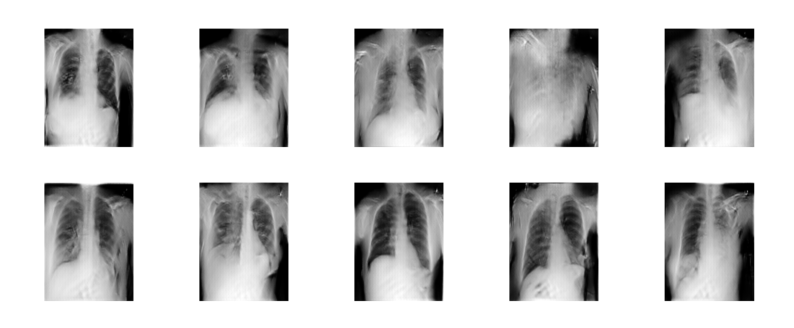

In [ ]:
# Visualizing the images in grayscale
image_paths = df['path'].values
# Number of rows and columns in the grid
num_rows = 2
num_cols = 5

# Calculate the total number of images to display (should be <= num_rows * num_cols)
num_images_to_display = min(len(image_paths), num_rows * num_cols)

# Increase the size of each individual image
image_size = (1024, 1024)  # Adjust the desired size

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))

# Flatten the axes array to simplify indexing
axes = np.ravel(axes)

# Loop through and display the first 10 images in the grid
for i in range(num_images_to_display):
    if i < len(image_paths):
        # Load the color image
        color_image = Image.open(image_paths[i])

        # Convert to grayscale
        grayscale_image = color_image.convert("L")  # "L" mode indicates grayscale

        # Resize to the desired size
        grayscale_image = grayscale_image.resize(image_size)

        # Convert to a NumPy array
        grayscale_array = np.array(grayscale_image)

        # Ensure the shape is (192, 192, 1)
        grayscale_array = grayscale_array.reshape((*image_size, 1))

        # Display the grayscale image
        axes[i].imshow(grayscale_array[:, :, 0], cmap="gray")
        axes[i].axis('off')  # Hide axis labels and ticks
    else:
        # If there are fewer images than grid cells, leave the empty cells blank
        axes[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Display the grid of grayscale images
plt.show()


# The Makeup of the second CNN model
## The total number of generated GAN images 9927.
## In the second CNN model, these GANs will be added to only the Training dataset and  the model evaluated on the unseen test dataset.
## The number of synthetic GAN added to this model is 4500 which is about half 45% of the Infiltration Images
## The dataset extraction, concatnation and model biulding and performance metrics using this dataset are presented below

## Loading the Original Infiltration and Healthy Datasets

In [9]:
# Filter rows with 'Infiltration' label
Infiltration_df = lungs_df[lungs_df['Finding Labels'] == "Infiltration" ]  # Assuming 'label' is the column containing class labels


# Filter rows with 'normal' label, keeping only 10000 samples
normal_data = lungs_df[lungs_df['Finding Labels'] == 'No Finding'].sample(n=10000)

# Concatenate the 'Infiltration' and 'No Standing' subset data
subset_data = pd.concat([Infiltration_df, normal_data])

# Reorganizing the index
subset_data = subset_data.sample(frac=1, random_state=42).reset_index(drop=True)
subset_data


# This i
class_dataset = subset_data[['path','Infiltration']]
class_dataset = class_dataset.rename(columns={
    "Infiltration": "Labels",
})
# Defining the loading function
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height=128, target_width=128)
    image = (image)/255  # Normalize to [0, 1]
    return image, label

## Defining the X and y variable and splitting the dataset int training and test dataset


In [10]:
# Assuming you have a DataFrame 'lungs_df' with columns 'path' and 'Labels'
X = class_dataset["path"].values
y = class_dataset["Labels"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training and validation datasets
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Apply the image loading function to each sample in the datasets
dataset_train = dataset_train.map(load_and_preprocess_image)
dataset_val = dataset_val.map(load_and_preprocess_image)
#
# # Batch and shuffle the datasets
# batch_size = 32
# dataset_train = dataset_train.batch(batch_size).shuffle(buffer_size=len(X_train))
# dataset_val = dataset_val.batch(batch_size)


## Defining the number of Synthetic Dataset needed for this  for the second CNN model and concatnating the two X_train of the original images and the and the synthetic images including their y_labels

In [11]:
# sampling and subsetting the sythetic GANS
df1 = df.sample(n=4500)
dcgan_X_train = df1["path"].values
dcgan_y_train = df1["Labels"].values
X_train1 = np.concatenate([X_train, dcgan_X_train], axis=0)
y_train1 = np.concatenate([y_train, dcgan_y_train], axis=0)

# Defining the training Data an preprocesing it
dataset_train = tf.data.Dataset.from_tensor_slices((X_train1, y_train1))
dataset_train = dataset_train.map(load_and_preprocess_image)

# Batch and shuffle the datasets
batch_size = 32
dataset_train = dataset_train.batch(batch_size).shuffle(buffer_size=len(X_train1))
dataset_val = dataset_val.batch(batch_size)



## Compiling and fitting the Second CNN model where the synthetic GANs are only in the training dataset

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the training dataset and validate on the validation dataset
epochs = 15
DCGAN_model1 = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, callbacks=[early_stopping])

Epoch 1/15
630/630 [==============================] - 3928s 998ms/step - loss: 0.5419 - accuracy: 0.6228 - val_loss: 0.6884 - val_accuracy: 0.5427
Epoch 2/15
630/630 [==============================] - 337s 138ms/step - loss: 0.5275 - accuracy: 0.6630 - val_loss: 0.6819 - val_accuracy: 0.5747
Epoch 3/15
630/630 [==============================] - 333s 138ms/step - loss: 0.5164 - accuracy: 0.6825 - val_loss: 0.6748 - val_accuracy: 0.5767
Epoch 4/15
630/630 [==============================] - 345s 138ms/step - loss: 0.5092 - accuracy: 0.6921 - val_loss: 0.6721 - val_accuracy: 0.5954
Epoch 5/15
630/630 [==============================] - 338s 138ms/step - loss: 0.4976 - accuracy: 0.7078 - val_loss: 0.6639 - val_accuracy: 0.5928
Epoch 6/15
630/630 [==============================] - 340s 139ms/step - loss: 0.4828 - accuracy: 0.7236 - val_loss: 0.6954 - val_accuracy: 0.5893
Epoch 7/15
630/630 [==============================] - 338s 138ms/step - loss: 0.4613 - accuracy: 0.7391 - val_loss: 0.7053 

In [13]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = DCGAN_model1.model.evaluate(dataset_val)
print("Validation accuracy:", validation_accuracy)

## Plotting the Training and validation accuracy curve

# Access training history for accuracy and loss
training_accuracy = DCGAN_model1.history['accuracy']
validation_accuracy = DCGAN_model1.history['val_accuracy']
training_loss = DCGAN_model1.history['loss']
validation_loss = DCGAN_model1.history['val_loss']

123/123 [==============================] - 58s 472ms/step - loss: 0.6639 - accuracy: 0.5928
Validation accuracy: 0.5928388833999634


## Pltotting the third models training and validation accuracies and loss


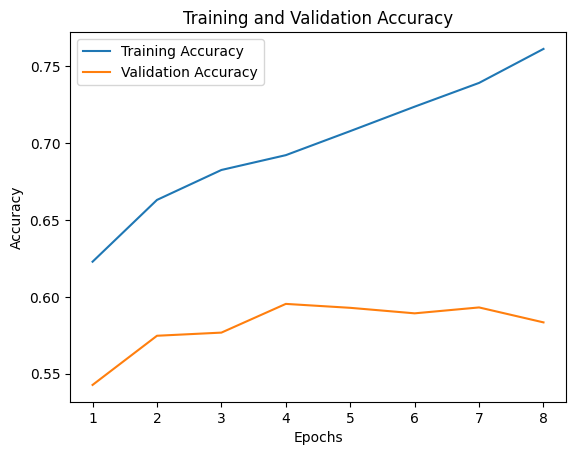

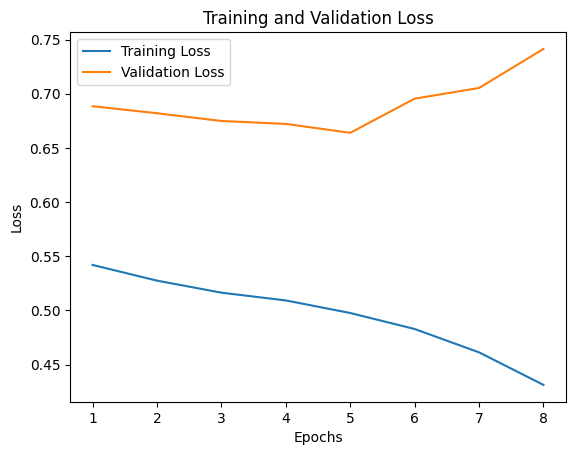

In [14]:


# Plot training and validation accuracy
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/DCGANtrain_validation12.png")

# Training and validation loss plot
plt.figure()  # Create a new figure for the loss plot
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/DCGANtrain_validation_loss12.png")

plt.show()

## Printing the classification report and plotting the confusion matrix

123/123 [==============================] - 52s 425ms/step - loss: 0.6639 - accuracy: 0.5928
Validation loss: 0.6639038324356079
123/123 [==============================] - 53s 428ms/step
              precision    recall  f1-score   support

         0.0       0.58      0.74      0.65      2012
         1.0       0.61      0.44      0.51      1898

    accuracy                           0.59      3910
   macro avg       0.60      0.59      0.58      3910
weighted avg       0.60      0.59      0.58      3910



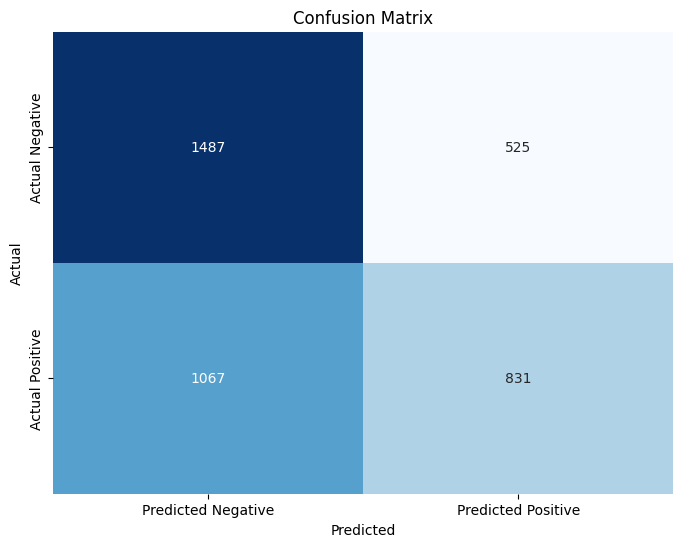

In [15]:
# Evaluate the model on the validation data
validation_loss = model.evaluate(dataset_val)[0]
print("Validation loss:", validation_loss)

# Get predicted probabilities for the validation set
validation_probabilities = model.predict(dataset_val)

# Convert predicted probabilities to class predictions
y_val_predictions = (validation_probabilities > 0.5).astype(int)

## printing the classsification reports

BMReport = classification_report(y_val, y_val_predictions)
print(BMReport)
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_val, y_val_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("/content/drive/MyDrive/GANPlots/SecondConfusion.png")
plt.show()

## Plotting the ROC curve and printing the AUC of the third model


123/123 [==============================] - 2s 13ms/step
AUC: 0.64


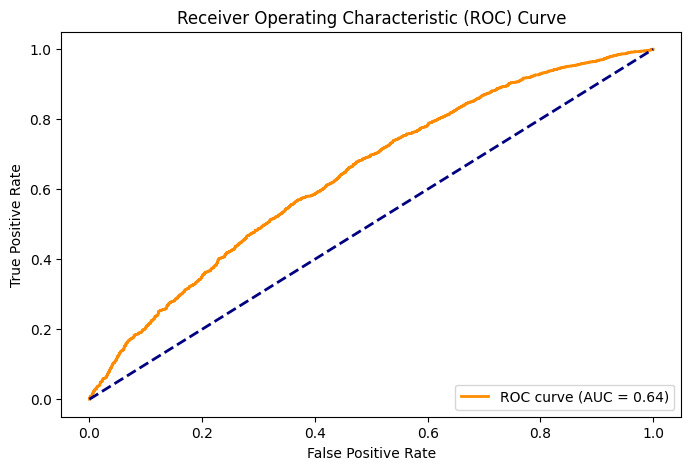

In [21]:
# Assuming your model is already trained and saved as 'model'

# Function to preprocess data for ROC curve
def preprocess_for_roc_curve(file_paths, labels):
    images = [load_and_preprocess_image(file_path, label)[0] for file_path, label in zip(file_paths, labels)]
    return np.array(images), labels

# Preprocess the validation data for the ROC curve
X_val_preprocessed, y_val = preprocess_for_roc_curve(X_val, y_val)

# Get predicted probabilities for the positive class
y_val_probabilities = model.predict(X_val_preprocessed)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("AUC: {:.2f}".format(roc_auc))

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


# Third CNN model. Add add the healthy images, the GANs and the infiltration images together before splitting it into training and validation dataset.
## Preprocessing the dataset and setting subsetting all the datasets for this analysis

In [ ]:
# Filter rows with 'edema' label
Infiltration_df = lungs_df[lungs_df['Finding Labels'] == "Infiltration" ]  # Assuming 'label' is the column containing class labels


# Filter rows with 'normal' label, keeping only 3000 samples
normal_data = lungs_df[lungs_df['Finding Labels'] == 'No Finding'].sample(n=10000)

# Concatenate the 'Edema' and 'No Standing' subset data
subset_data = pd.concat([Infiltration_df, normal_data])

# Reorganizing the index
subset_data = subset_data.sample(frac=1, random_state=42).reset_index(drop=True)
subset_data


# This i
class_dataset = subset_data[['path','Infiltration']]
class_dataset = class_dataset.rename(columns={
    "Infiltration": "Labels",
})
df1 = df.sample(n=4500)
subset_data = pd.concat([class_dataset,df1])
subset_data

,path,Labels
0,/content/drive/MyDrive/NIH/images_009/images/0...,1.0
1,/content/drive/MyDrive/NIH/images_004/images/0...,0.0
2,/content/drive/MyDrive/NIH/images_008/images/0...,0.0
3,/content/drive/MyDrive/NIH/images_004/images/0...,1.0
4,/content/drive/MyDrive/NIH/images_010/images/0...,1.0
...,...,...
2371,/content/drive/My Drive/DCGAN5/epoch_1838/epoc...,1.0
360,/content/drive/My Drive/DCGAN5/epoch_1798/epoc...,1.0
632,/content/drive/My Drive/DCGAN5/epoch_1803/epoc...,1.0
4312,/content/drive/My Drive/DCGAN5/epoch_1877/epoc...,1.0


## Splitting the dataset into training and testing dataset and and preprocr=essing the dataset into numpy array for the cnn model

In [ ]:
X = subset_data["path"].values  # Input features (file paths)
y = subset_data["Labels"].values  # Target labels

# Split the data into 80% training and 20% validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing the dataset for the CNN model
X_train2 = np.array([load_and_preprocess_image(file_path) for file_path in X_train2])
X_val2 = np.array([load_and_preprocess_image(file_path) for file_path in X_val2])

In [ ]:
# Defining the part to the pickle file
pickle_file_path = "/content/drive/MyDrive/X_train2.pkl"

# Create and write to the pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(X_train2, file)

print(f'Successfully created {pickle_file_path}')

Successfully created /content/drive/MyDrive/X_train2.pkl


In [ ]:

# Replace 'MyFiles/your_file.pkl' with the actual path to your file
file_path = "/content/drive/MyDrive/X_train2.pkl"

with open(file_path, 'rb') as file:
    X_train2 = pickle.load(file)

X_train2

array([[[[0.01960784, 0.01960784, 0.01960784],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.07843137, 0.07843137, 0.07843137],
         [0.18039216, 0.18039216, 0.18039216]],

        [[0.01568627, 0.01568627, 0.01568627],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.01960784, 0.01960784, 0.01960784]

In [ ]:
# Defining the part to the pickle file
pickle_file_path1 = "/content/drive/MyDrive/X_val2.pkl"

# Create and write to the pickle file
with open(pickle_file_path1, 'wb') as file:
    pickle.dump(X_val2, file)

print(f'Successfully created {pickle_file_path}')

Successfully created /content/drive/MyDrive/X_train2.pkl


In [ ]:

# Replace 'MyFiles/your_file.pkl' with the actual path to your file
file_path = "/content/drive/MyDrive/X_val2.pkl"

with open(file_path, 'rb') as file:
    X_val2 = pickle.load(file)

X_val2

array([[[[0.02352941, 0.02352941, 0.02352941],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        [[0.02352941, 0.02352941, 0.02352941],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098],
         [0.02745098, 0.02745098, 0.02745098]],

        ...,

        [[0.09019608, 0.09019608, 0.09019608],
         [0.22352941, 0.22352941, 0.22352941]

## Trianing the third CNN model and plotting the accuracy metrics

Epoch 1/15
602/602 [==============================] - 8s 13ms/step - loss: 0.5269 - accuracy: 0.6871 - val_loss: 0.5420 - val_accuracy: 0.6788
Epoch 2/15
602/602 [==============================] - 6s 10ms/step - loss: 0.5217 - accuracy: 0.6956 - val_loss: 0.5378 - val_accuracy: 0.6719
Epoch 3/15
602/602 [==============================] - 6s 10ms/step - loss: 0.5128 - accuracy: 0.7044 - val_loss: 0.5505 - val_accuracy: 0.6723
Epoch 4/15
602/602 [==============================] - 6s 10ms/step - loss: 0.5002 - accuracy: 0.7177 - val_loss: 0.5547 - val_accuracy: 0.6717
Epoch 5/15
151/151 [==============================] - 1s 5ms/step - loss: 0.5378 - accuracy: 0.6719
Validation accuracy: 0.6719334721565247


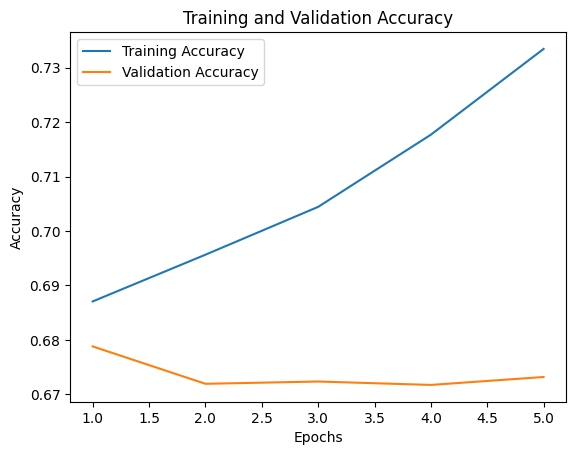

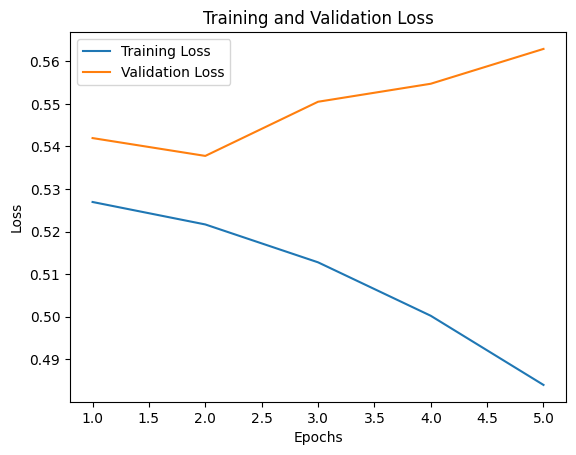

In [ ]:

# Train the model and get the training history
DCGAN_model2 = model.fit(X_train2, y_train2, epochs=num_epochs, validation_data=(X_val2, y_val2), callbacks=[early_stopping])

# Evaluate the model on the validation data
validation_loss, validation_accuracy = DCGAN_model2.model.evaluate(X_val2, y_val2)
print("Validation accuracy:", validation_accuracy)

## Plotting the Training and validation accuracy curve

# Access training history for accuracy and loss
training_accuracy = DCGAN_model2.history['accuracy']
validation_accuracy = DCGAN_model2.history['val_accuracy']
training_loss = DCGAN_model2.history['loss']
validation_loss = DCGAN_model2.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/DCGANtrain_validation2.png")

# Training and validation loss plot
plt.figure()  # Create a new figure for the loss plot
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/GANPlots/DCGANtrain_validation_loss2.png")

plt.show()

151/151 [==============================] - 1s 5ms/step - loss: 0.5378 - accuracy: 0.6719
Validation loss: 0.5377626419067383
151/151 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65      1918
         1.0       0.79      0.61      0.69      2892

    accuracy                           0.67      4810
   macro avg       0.68      0.69      0.67      4810
weighted avg       0.70      0.67      0.67      4810



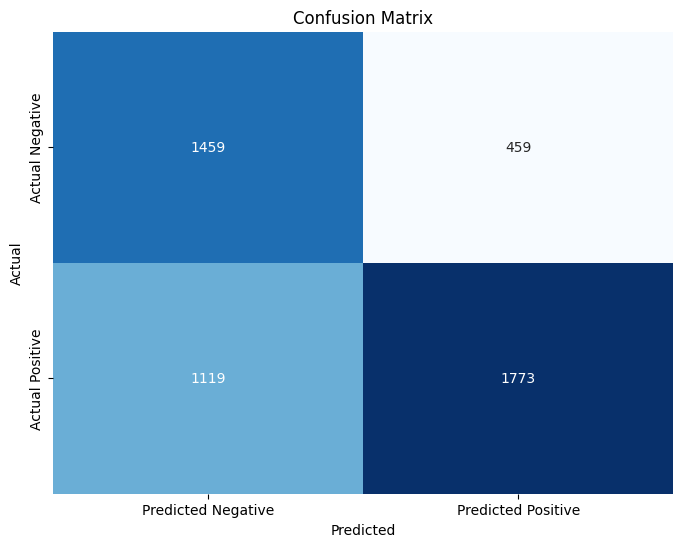

In [ ]:
# Evaluate the model on the validation data
validation_loss = model.evaluate(X_val2, y_val2)[0]
print("Validation loss:", validation_loss)

# Get predicted probabilities for the validation set
validation_probabilities = model.predict(X_val2)

# Convert predicted probabilities to class predictions
y_val_predictions = (validation_probabilities > 0.5).astype(int)

## printing the classsification reports

BMReport = classification_report(y_val2, y_val_predictions)
print(BMReport)
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_val2, y_val_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


151/151 [==============================] - 1s 5ms/step - loss: 0.5378 - accuracy: 0.6719
Validation loss: 0.5377626419067383
151/151 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65      1918
         1.0       0.79      0.61      0.69      2892

    accuracy                           0.67      4810
   macro avg       0.68      0.69      0.67      4810
weighted avg       0.70      0.67      0.67      4810



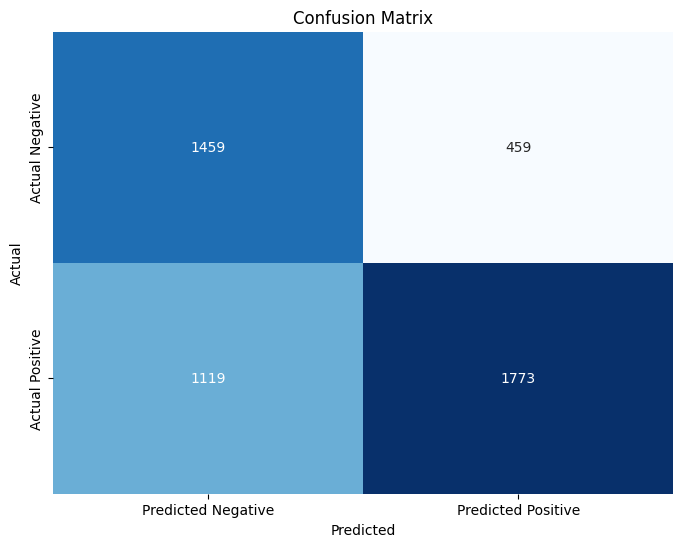

In [ ]:
# Evaluate the model on the validation data
validation_loss = model.evaluate(X_val2, y_val2)[0]
print("Validation loss:", validation_loss)

# Get predicted probabilities for the validation set
validation_probabilities = model.predict(X_val2)

# Convert predicted probabilities to class predictions
y_val_predictions = (validation_probabilities > 0.5).astype(int)

## printing the classsification reports

BMReport = classification_report(y_val2, y_val_predictions)
print(BMReport)
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_val2, y_val_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("/content/drive/MyDrive/GANPlots/ThirdConfusion.png")
plt.show()

151/151 [==============================] - 1s 4ms/step
GAN in Entire Dataset AUC: 0.76


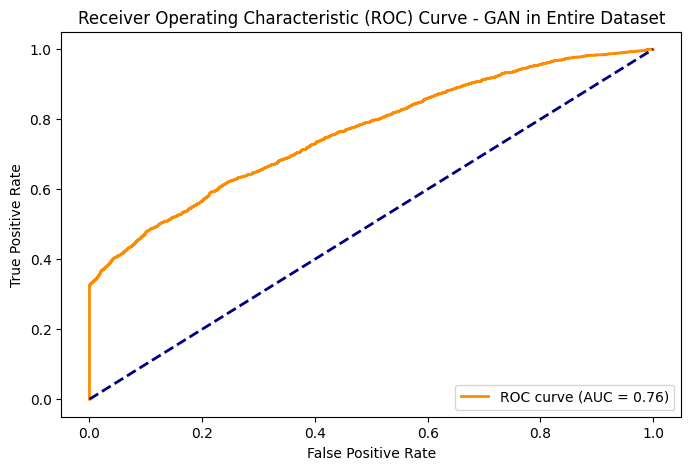

In [ ]:
save_path = ("/content/drive/MyDrive/GANPlots/ThirdBM_roc.png")
plot_roc_curve(model, X_val2, y_val2, model_name='GAN in Entire Dataset', save_path= save_path)